In [2]:
from jax import numpy as jnp, random, jit
import phayes
import random as rand
import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_enable_x64", True)


from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter
import numpy as np
from pytket.circuit import CircBox, QControlBox
from pytket.extensions.qiskit import AerStateBackend
from pytket.extensions.nexus import NexusBackend, QuantinuumConfig, Nexus

/tmp/ipykernel_103/4013193879.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [3]:
"""
m: integer number of repetitions
omega: amount of Z rotation applied
state_prep_circuit: Circuit that prepares an eigenvector of unitary_circuit
unitary_circuit: circuit implementing a black box unitary
"""
def build_phase_estimation_circuit(
    m: int, omega: float, state_prep_circuit: Circuit, unitary_circuit: Circuit
) -> Circuit:
    # Define a Circuit with a measurement and prep register
    qpe_circ: Circuit = Circuit()
    n_state_prep_qubits = state_prep_circuit.n_qubits
    measurement_register = qpe_circ.add_q_register("m", 1)
    state_prep_register = qpe_circ.add_q_register("p", n_state_prep_qubits)
    qpe_circ.add_circuit(state_prep_circuit, list(state_prep_register))

    # Add Hadamard gate to the measurement register
    qpe_circ.H(measurement_register[0])
    # Create a controlled unitary with a single control qubit
    unitary_circuit.name = "U"
    controlled_u_gate = QControlBox(CircBox(unitary_circuit), 1)
    # Run the controlled unitary m times
    for _ in range(m):
        qpe_circ.add_qcontrolbox(
            controlled_u_gate, list(measurement_register) + list(state_prep_register)
        )
    #alternate method of putting m iterations of U inside a single QControlBox
    
    # Um_circ = Circuit()
    # Um_state_register = Um_circ.add_q_register("v", unitary_circuit.n_qubits)
    # for _ in range(m):
    #     Um_circ.add_circuit(unitary_circuit, list(Um_state_register))
    # Um_circ.name = "U^m"
    # controlled_Um_gate = QControlBox(CircBox(Um_circ), 1)

    qpe_circ.U1(omega, measurement_register[0])
    qpe_circ.H(measurement_register[0])
    qpe_circ.measure_register(measurement_register, "c")
    return qpe_circ

In [4]:
"""
runs phase estimation given the parameters, and then returns which outcome was most frequent
out of n_shots
"""
def get_next_digit(m: int, omega: float, state_prep_circuit: Circuit, unitary_circuit: Circuit,
                   backend=AerStateBackend(), n_shots=1000):
    qpe_circ = build_phase_estimation_circuit(m, omega, state_prep_circuit, unitary_circuit)
    compiled_circ = backend.get_compiled_circuit(qpe_circ)
    result = backend.run_circuit(compiled_circ, n_shots)
    counts = result.get_counts()

    #make a list with the same distribution as observed
    items, weights = zip(*counts.items())
    random_list = rand.choices([item[0] for item in items], weights=weights, k=n_shots)
    return random_list

In [5]:
def bayesian_pe(state_prep_circuit, unitary_circuit, num_experiments=20, n_shots_per_experiment=1):
    state = phayes.init(J=100)
    k_max = jnp.inf
    
    states = [state]
    ks = []
    betas = []
    for i in range(num_experiments):
        k, beta = jit(phayes.get_k_and_beta)(states[i], k_max=k_max)
        ks.append(k)
        betas.append(beta)
        m = get_next_digit(k, beta, state_prep_circuit, unitary_circuit, n_shots=n_shots_per_experiment)
        new_state = jit(phayes.update)(states[i], m, k, beta)
        states.append(new_state)
        mode = 'Fourier' if states[i+1].fourier_mode else 'von Mises'
        print(f"Experiment {i+1}/{num_experiments}: k={k}, beta={beta}, {mode}, Holevo variance={phayes.holevo_variance(states[i+1])}")
    return states

In [6]:
### SIMPLE EXAMPLE
input_angle = 0.52536912 # set this to what you please
true_phi = input_angle/2

prep_circuit = Circuit(1).X(0)  # prepare the |1> eigenstate of U1
unitary_circuit = Circuit(1).U1(input_angle, 0)  # Base unitary for controlled U ops


states = bayesian_pe(prep_circuit, unitary_circuit, num_experiments=5, n_shots_per_experiment=20)

estimated_phase = phayes.circular_mean(states[-1])
print("Estimated Phase:", estimated_phase)
print("True Phase:", true_phi)

error = round(abs(input_angle - (2 * estimated_phase)), 3)
print("Error:",error)

Experiment 1/5: k=1, beta=1.5707963267948966, Fourier, Holevo variance=0.10249999999999959
Experiment 2/5: k=3, beta=0.0, Fourier, Holevo variance=0.013136653759206585
Experiment 3/5: k=14, beta=1.9138718893515672, von Mises, Holevo variance=0.002976941676316569
Experiment 4/5: k=18, beta=0.5482042692475948, von Mises, Holevo variance=0.0002580334656594463
Experiment 5/5: k=62, beta=1.2188733519977926, von Mises, Holevo variance=2.633582159039527e-05
Estimated Phase: -1.7468302105802818
True Phase: 0.26268456
Error: 4.019


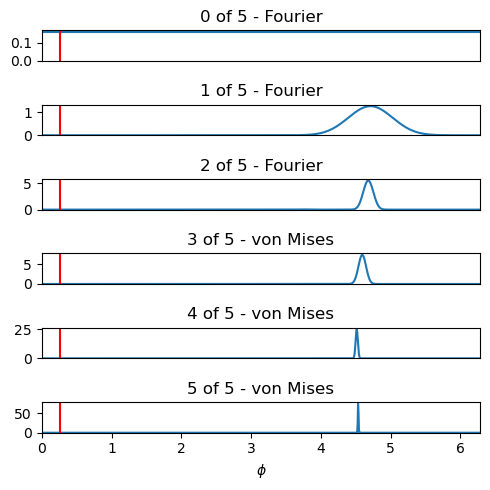

In [7]:
pdf_linsp = jnp.linspace(0, 2 * jnp.pi, 1000)
num_experiments=5
fig, axes = plt.subplots(num_experiments + 1, figsize=(5, num_experiments))
for i, s in enumerate(states):
    mode = 'Fourier' if states[i].fourier_mode else 'von Mises'
    axes[i].plot(pdf_linsp, phayes.pdf(pdf_linsp, s), label=f"Step {i}")
    axes[i].axvline(true_phi, c='red')
    axes[i].set_title(f"{i} of {num_experiments} - {mode}")
    axes[i].set_xlim(0, 2 * jnp.pi)
    axes[i].set_ylim(0, axes[i].get_ylim()[1])
    if i < num_experiments:
        axes[i].set_xticks([])
axes[-1].set_xlabel(r"$\phi$")
fig.tight_layout()